# Deep Learning con Python

Ejercicio final para la asignatura de Deep Learning en el Máster de Big Data & Data Science. Esta prueba consiste en la predicción de una variable objetivo, que será el considerar si el nivel de **ozono** está elevado o no. Se trata de un problema de clasificación binaria. 

Para ello, generaremos un modelo de **Red Neuronal Recurrente** que prediga esta variable.

## Recurrent Neural Networks
En las Redes Neuronales Recurrentes guardamos la salida de las activaciones de una o más capas de nuestra red. Habitualmente estas son activaciones ocultas. Entonces, la próxima vez que devolvemos el input a la red, incluimos el output anteriormente guardado dentro de los outputs normales de la capa anterior. Por ejemplo, si una capa oculta tiene 10 nodos de input regulares y 128 nodos coultos en la capa, entonces tendrá 138 nodos totales. Si es la primera vez que se intenta alimentar esa capa, entonces habrá que rellenar esos 128 inputos con 0s.

![Figura 1](https://cdn-images-1.medium.com/max/1600/1*NKhwsOYNUT5xU7Pyf6Znhg.png)

## El problema de Vanishing gradient

Este problema es la dificultad encontrada en el entrenamiento de redes neuronales artificales basadas en aprendizaje gradiente y backpropagation. En estos métodos, cada peso de la red neuronal recibe una actualización proporcional al la derivada de la función de error respecto al peso actual en cada iteración del entrenamiento. El problema en algunos casos es, el gradiente será muy pequeño, evitando que el peso cambie de valor. En el peor de los casos, esto puede detener completamente la red neuronal de un entrenamiento posterior. Como un ejemplo de la causa del problema, las funciones tales como la función tangente hiperbólica, tienen gradientes en el range (0,1), y la propagación hacia atrás calcula los gradientes por la regla de la cadena. Esto tiene un efecto de multipllicar ``n`` de estos pequeños números para calcular gradientes de las capas "frontales" en una red de ``n`` capas, lo que significa que el gradiente (o la señal de erorr) disminuye exponencialmente con ``n`` mientras que las capas frontales se entrenan muy lentamente

![Figura 2](https://cdn-images-1.medium.com/max/1460/1*FWy4STsp8k0M5Yd8LifG_Q.png)

## Long Short Term Memory (LSTM)

Los bloques (o unidades) de LSTM son una construicción de capas de una red recurrente neuronal (RNN). Una RNN compuesta de unidades LSTM se le llama una LSTM network. Una unidad común de LSTM está compuesta por una célula, una puerta de input, una puerta de output y una puerta de olvidado (forget gate). La célula es responsable de "recordar" los valores de los valores del intervalo arbitrarios, de ahí la "memoria" de LSTM. Cada una de las 3 puertas anteriormente nombradas, son lo que conocemos como una "neurona artificial convencional", como una red neuronal multicapa. Lo que hace es, computar una activación (usando la función de activación) de una suma de pesos. Intuitivamente, pueden nombrarse como los reguladores del flujo de los valores (flow of values) que va a través de las LSTM, de ahí la denominación de "puerta". Hay conexiones entre esta puerta y la célula.

La expresión largo-corto-plazo (long short term) se refiere al hecho de que las redes LSTM son un modelo de memoria a corto y largo plazo las cuales duran un periodo de tiempo. Una LSTM está bien optimizada para clasificar, procesar y predecir series temporales, dados unos periodos de tiempo de un tamaño desconocido y una duración entre los eventos importantes. Las LSTM han sido desarrolladas para tratar con el problema del``exploding`` y ``vanishing`` ``gradient``cuando se entrenan las redes neuronales tradicionales.

![Figura 3](https://cdn-images-1.medium.com/max/1600/0*LyfY3Mow9eCYlj7o.)

### Componentes de una LSTM
 * Forget gate "f" (una red neuronal con sigmoide)
 * Candidate layer "C" (una RN con Tanh)
 * Input Gate "I" (Una RN con sigmoide)
 * Ouput Gate "O" (Una RN con sigmoide)
 * Hidden State "H" (Un vector)
 * Memory State "C" (Un vector)
 * Inputs de la célula LSTMen cualquier estado son X<sub>t</sub> (input actual) , H<sub>t-1</sub> (estado anterior oculto) y C<sub>t-1</sub> (estado de la memoria previo.
 * Outputs de la célula LSTM son H<sub>t</sub> (estado oculto actual) y C<sub>t</sub> (estado de la memoria actual).



### Cargamos las librerías de trabajo

## Carga de Librerías de trabajo

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

print(os.listdir("/home/jmgonzalezro/jmgonzalezro@gmail.com/Data Analysis/Universidad/17 Deep Learning/Practica"))

['onehr.data', 'ozone.csv', 'eighthr.names', '.git', 'onehr.names', 'Practica.ipynb', 'eighthr.data']


## Carga del dataset

In [2]:
ozoneDF = pd.read_csv("/home/jmgonzalezro/jmgonzalezro@gmail.com/Data Analysis/Universidad/17 Deep Learning/Practica/ozone.csv", index_col = "Date", parse_dates = ["Date"])

## Preprocesado y creación de datasets

In [3]:
ozoneDF.head()

WSR0 WSR1 WSR2 WSR3 WSR4 WSR5 WSR6 WSR7 WSR8 WSR9  ...  RH50  \
Date                                                          ...         
1998-01-01  0.8  1.8  2.4  2.1    2  2.1  1.5  1.7  1.9  2.3  ...  0.15   
1998-01-02  2.8  3.2  3.3  2.7  3.3  3.2  2.9  2.8  3.1  3.4  ...  0.48   
1998-01-03  2.9  2.8  2.6  2.1  2.2  2.5  2.5  2.7  2.2  2.5  ...   0.6   
1998-01-04  4.7  3.8  3.7  3.8  2.9  3.1  2.8  2.5  2.4  3.1  ...  0.49   
1998-01-05  2.6  2.1  1.6  1.4  0.9  1.5  1.2  1.4  1.3  1.4  ...     ?   

              U50    V50  HT50     KI    TT    SLP SLP_ Precp target  
Date                                                                  
1998-01-01  10.67  -1.56  5795  -12.1  17.9  10330  -55     0    0.0  
1998-01-02   8.39   3.84  5805  14.05    29  10275  -55     0    0.0  
1998-01-03   6.94    9.8  5790   17.9  41.3  10235  -40     0    0.0  
1998-01-04   8.73  10.54  5775  31.15  51.7  10195  -40  2.08    0.0  
1998-01-05      ?      ?     ?      ?     ?      ?    ?  0.58    0.0  

[5 rows x 73 columns]

Obseravmos que tenemos las siguientes variables importantes:

* WSR_PK: Continua. peek wind speed -- resultant (meaning average of wind vector)
* WSR_AV: continuous. average wind speed
* T_PK: continuous. Peak T
* T_AV: continuous. Average T
* T85: continuous. T at 850 hpa level (or about 1500 m height)
* RH85: continuous. Relative Humidity at 850 hpa
* U85: continuous. (U wind - east-west direction wind at 850 hpa)
* V85: continuous. V wind - N-S direction wind at 850
* HT85: continuous. Geopotential height at 850 hpa, it is about the same as height at low * altitude
* T70: continuous. T at 700 hpa level (roughly 3100 m height)
* RH70: continuous.
* U70: continuous.
* V70: continuous.
* HT70: continuous.
* T50: continuous. T at 500 hpa level (roughly at 5500 m height)
* RH50: continuous.
* U50: continuous.
* V50: continuous.
* HT50: continuous.
* KI: continuous. K-Index
* TT: continuous. T-Totals
* SLP: continuous. Sea level pressure
* SLP_: continuous. SLP change from previous day
* Precp: continuous. -- precipitation

Además de:

* O 3 - Local ozone peak prediction
* Upwind - Upwind ozone background level
* EmFactor - Precursor emissions related factor
* Tmax - Maximum temperature in degrees F
* Tb - Base temperature where net ozone production begins (50 F)
* SRd - Solar radiation total for the day
* WSa - Wind speed near sunrise (using 09-12 UTC forecast mode)
* WSp - Wind speed mid-day (using 15-21 UTC forecast mode)

La **target**, que sería nuestro último atributo llamado ``target``

In [4]:
# Compruebo que no tiene duplicados
print("El número de duplicados es:\n",ozoneDF.duplicated().sum(),
      "\n\nLos tipos de varibales son:\n", ozoneDF.dtypes)

# Compruebo los valores de cada una de las variables
# ozoneDF.dtypes,

# Evidentemente son todas objetos excepto la variable objetivo que es un numero

El número de duplicados es:
 8 

Los tipos de varibales son:
 WSR0       object
WSR1       object
WSR2       object
WSR3       object
WSR4       object
           ...   
TT         object
SLP        object
SLP_       object
Precp      object
target    float64
Length: 73, dtype: object


In [5]:
ozoneDF.describe()

target
count  2534.000000
mean      0.063141
std       0.243265
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000

In [6]:
# Compruebo nulls
ozoneDF.isnull().sum()

WSR0      0
WSR1      0
WSR2      0
WSR3      0
WSR4      0
         ..
TT        0
SLP       0
SLP_      0
Precp     0
target    0
Length: 73, dtype: int64

In [7]:
ozoneDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2534 entries, 1998-01-01 to 2004-12-31
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WSR0    2534 non-null   object 
 1   WSR1    2534 non-null   object 
 2   WSR2    2534 non-null   object 
 3   WSR3    2534 non-null   object 
 4   WSR4    2534 non-null   object 
 5   WSR5    2534 non-null   object 
 6   WSR6    2534 non-null   object 
 7   WSR7    2534 non-null   object 
 8   WSR8    2534 non-null   object 
 9   WSR9    2534 non-null   object 
 10  WSR10   2534 non-null   object 
 11  WSR11   2534 non-null   object 
 12  WSR12   2534 non-null   object 
 13  WSR13   2534 non-null   object 
 14  WSR14   2534 non-null   object 
 15  WSR15   2534 non-null   object 
 16  WSR16   2534 non-null   object 
 17  WSR17   2534 non-null   object 
 18  WSR18   2534 non-null   object 
 19  WSR19   2534 non-null   object 
 20  WSR20   2534 non-null   object 
 21  WSR21   2534 non-nu

In [8]:
ozoneDF.describe()

# Con este describe compruebo que no hay valores que estén fuera de rango 0-1 en la variable target.

target
count  2534.000000
mean      0.063141
std       0.243265
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000

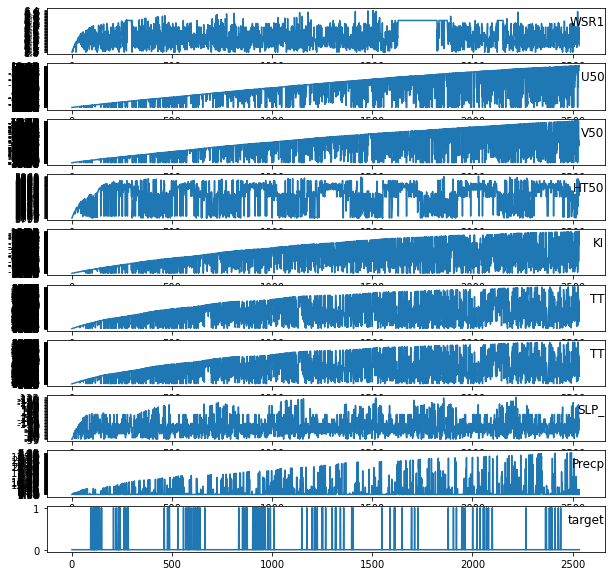

In [11]:
values = ozoneDF.values
groups = [1,64,65,66,67,68,68,70,71,72]
i = 1
plt.figure(figsize = (10,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(ozoneDF.columns[group], y = 0.5, loc = "right")
    i += 1

plt.show()

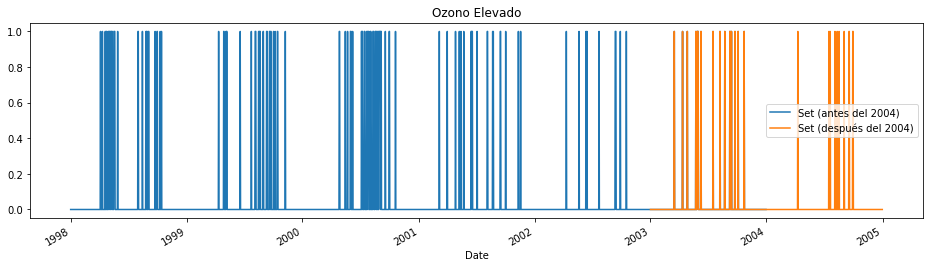

In [42]:
# Visualicemos la variable objetivo a través del tiempo
ozoneDF["target"][:"2003"].plot(figsize= (16,4), legend = True)
ozoneDF["target"]["2003":].plot(figsize = (16,4), legend = True)
plt.legend(["Set (antes del 2004)", "Set (después del 2004)"])
plt.title("Ozono Elevado")
plt.show()

Time to work on the dataset!

In [13]:
ozoneDF = ozoneDF.replace("?", 0)
# Cambiamos todos los valores "?" que hay en el dataset por valores 0

In [16]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder

values = ozoneDF.values
# integer encode direction
encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [17]:
scaled

array([[0.10666668, 0.23376623, 0.3380282 , ..., 0.2909091 , 0.        ,
        0.        ],
       [0.37333333, 0.41558442, 0.46478873, ..., 0.2909091 , 0.        ,
        0.        ],
       [0.3866667 , 0.36363637, 0.36619717, ..., 0.34545457, 0.        ,
        0.        ],
       ...,
       [0.10666668, 0.1038961 , 0.1690141 , ..., 0.36363637, 0.        ,
        0.        ],
       [0.17333333, 0.11688311, 0.21126762, ..., 0.38181818, 0.00242131,
        0.        ],
       [0.20000002, 0.16883117, 0.2535211 , ..., 0.4       , 0.        ,
        0.        ]], dtype=float32)

In [18]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        # agg = agg.dropna()
    return agg



# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.106667   0.233766   0.338028   0.287671   0.277778   0.283784   
2   0.373333   0.415584   0.464789   0.369863   0.458333   0.432432   
3   0.386667   0.363636   0.366197   0.287671   0.305556   0.337838   
4   0.626667   0.493506   0.521127   0.520548   0.402778   0.418919   
5   0.346667   0.272727   0.225352   0.191781   0.125000   0.202703   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var64(t)  var65(t)  \
1   0.202703   0.226667   0.206522    0.270588  ...      0.48  0.406948   
2   0.391892   0.373333   0.336957    0.400000  ...      0.60  0.381634   
3   0.337838   0.360000   0.239130    0.294118  ...      0.49  0.412884   
4   0.378378   0.333333   0.260870    0.364706  ...      0.00  0.260475   
5   0.162162   0.186667   0.141304    0.164706  ...      0.09  0.469623   

   var66(t)  var67(t)  var68(t)  var69(t)  var70(t)  var71(t)  var72(t)  \
1  0.528807  0.973177  0.716456  0.564621  0.992754  0.290909  0.000000   
2  0.634462  0.970662  0.755443  0.742238  0.988889  0.345455  0.000000   
3  0.647580  0.968148  0.889620  0.892419  0.985024  0.345455  0.100726   
4  0.460734  0.000000  0.574177  0.145848  0.000000  0.490909  0.028087   
5  0.660698  0.967309  0.857215  0.813718  0.977778  0.490909  0.282809   

   var73(t)  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
5       0.0  

[5 rows x 146 columns]

In [23]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2533 entries, 1 to 2533
Columns: 102 entries, var1(t-1) to var73(t)
dtypes: float32(102)
memory usage: 1.1 MB


In [25]:
# tiramos las columnas que no queremos predecir
reframed.drop(reframed.columns[[74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101]], axis = 1, inplace = True)

In [38]:
values = reframed.values

n_test_hours = 365 * 24
n_train_hours = values.shape[0] -n_test_hours
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(0, 1, 73) (0,) (2533, 1, 73) (2533,)
